<a href="https://colab.research.google.com/github/XeniaLLL/ETM/blob/main/Demo_for_UOT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Code Demo for UOT

To start with, we should prepare the data.

In [ ]:
import numpy as np
import matplotlib.pylab as pl
import ot
import torch
import torch.nn as nn
import torch.optim as optim
import ot.plot
import cvxpy as cp

n = 50 # nb samples
n_noise = 10

mu_s = np.array([-1, -1])
cov_s = np.array([[1, 0], [0, 1]])

mu_t = np.array([4, 4])
cov_t = np.array([[1, -.8], [-.8, 1]])

np.random.seed(0)
xs = ot.datasets.make_2D_samples_gauss(n - n_noise, mu_s, cov_s)
xt = ot.datasets.make_2D_samples_gauss(n - n_noise, mu_t, cov_t)

xs = np.concatenate((xs, ((np.random.rand(n_noise, 2) - 6))), axis=0)
xt = np.concatenate((xt, ((np.random.rand(n_noise, 2) + 8))), axis=0)

a, b = np.ones((n,)) / n, np.ones((n,)) / n  # uniform distribution on samples

# loss matrix
cost = ot.dist(xs, xt)
cost /= cost.max()
tau = 0.1
eps = 0.01

In [ ]:
def uot_helper(cost_mat,
               src_weight,
               trg_weight,
               tau_a,
               tau_b,
               epoch_iter = 1000):
    num_src_sample = cost_mat.shape[0]
    num_trg_sample = cost_mat.shape[1]
    zeta = 0
    u = np.ones((num_src_sample,)) / num_src_sample
    v = np.ones((num_trg_sample,)) / num_trg_sample
    for e in range(epoch_iter):
        den = np.sum(np.exp((u.reshape(-1, 1) - cost_mat) / eps), axis=0)
        term = np.exp(-cost_mat / eps) / den

        new_trg_weight = trg_weight * np.exp(-v / tau_b)
        sum_term = np.sum(term * new_trg_weight.reshape(1, -1), axis=1)
        u = (tau_a * eps / (tau_a + eps)) * (
            np.log(src_weight * np.exp(-zeta / tau_a)) - np.log(sum_term)
        )
        v = -eps*np.log(np.sum(np.exp((u.reshape(-1, 1) - cost_mat) / eps), axis=0))

    exp_u = np.exp(-u / tau_a)
    exp_v = np.exp(-v / tau_b)
    src_weight_sum = np.sum(src_weight * exp_u)
    trg_weight_sum = np.sum(trg_weight * exp_v)
    kappa = (tau_a * tau_b)/(tau_a + tau_b)
    zeta = kappa * np.log(src_weight_sum/trg_weight_sum)
    s = np.maximum(0, cost - u.reshape(-1, 1) - v.reshape(1, -1))

    return u, v, zeta, s

In [ ]:
u, v, zeta, s = uot_helper(cost,
                     a,
                     b,
                     tau,
                     tau)
print('value of u: ', u)
print('value of v: ', v)
print('value of zeta: ', zeta)
print('value of s: ', s)

value of u:  [ 0.00408919 -0.0174743   0.03113299  0.02875197  0.03615611  0.01078237
  0.02627902  0.02750577  0.0206375   0.05670616  0.08692051  0.04341839
  0.03538525  0.04644365 -0.01292689  0.03190896  0.1130748   0.04659917
 -0.00286083  0.05796355  0.10138521  0.03910898  0.0638103   0.05223199
  0.08364252  0.05294961  0.08242272  0.0343264   0.03520315  0.06469863
  0.06545513  0.10411233  0.04875789  0.06794859  0.06085751  0.0266908
  0.04980509  0.05091733  0.075255    0.04811007  0.34720193  0.30639294
  0.29437402  0.30435079  0.3146068   0.31937758  0.32277211  0.29498944
  0.29187982  0.30809247]
value of v:  [0.04033747 0.02896477 0.07147168 0.04717038 0.04324515 0.04887863
 0.04911542 0.04686499 0.05987216 0.04126824 0.05209172 0.04109835
 0.05897006 0.02385735 0.07101916 0.06480268 0.05895525 0.04344267
 0.04441968 0.05168976 0.03027409 0.0545473  0.0278998  0.05910222
 0.04646768 0.03662407 0.03032812 0.03939207 0.0395545  0.03057378
 0.03151889 0.04441065 0.07191

That is, we can transfer UOT into OT problem.

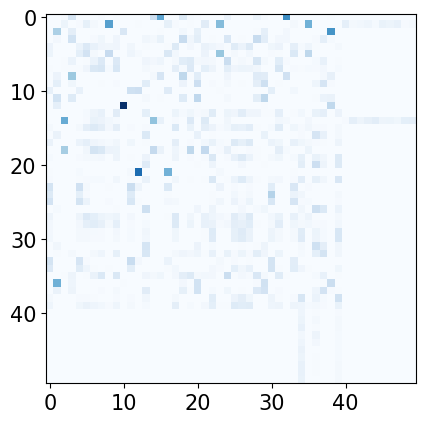

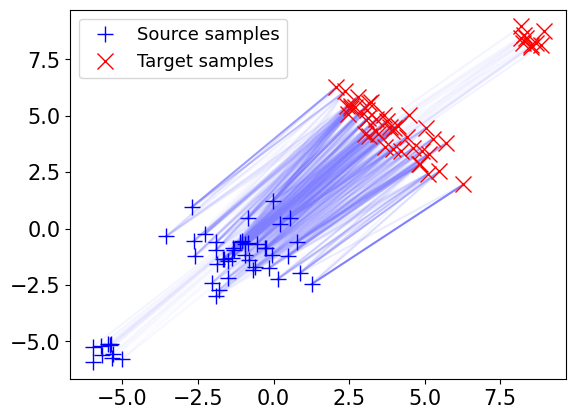

In [ ]:
pi_1 = ot.sinkhorn(a * np.exp(-(u+zeta)/tau), b * np.exp(-(v-zeta)/tau), cost + 100 * s, 0.1)

pl.figure(3)
pl.imshow(pi_1, interpolation="nearest", cmap='Blues')
pl.tick_params(labelsize=15)

pl.figure(4)
ot.plot.plot2D_samples_mat(xs, xt, pi_1, c=[0.5, 0.5, 1])
pl.plot(xs[:, 0], xs[:, 1], "+b", label="Source samples",markersize=12)
pl.plot(xt[:, 0], xt[:, 1], "xr", label="Target samples",markersize=12)
sss = pl.legend(loc=0,fontsize = 13)
pl.tick_params(labelsize=15)

sss.set_draggable(True)

pl.show()

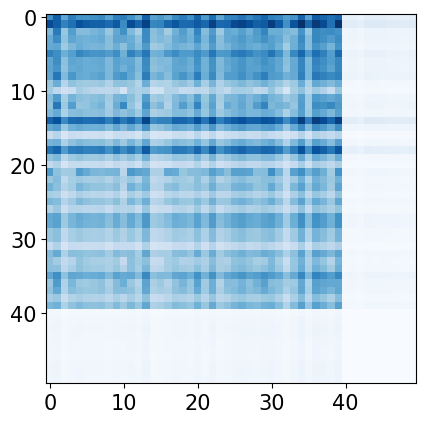

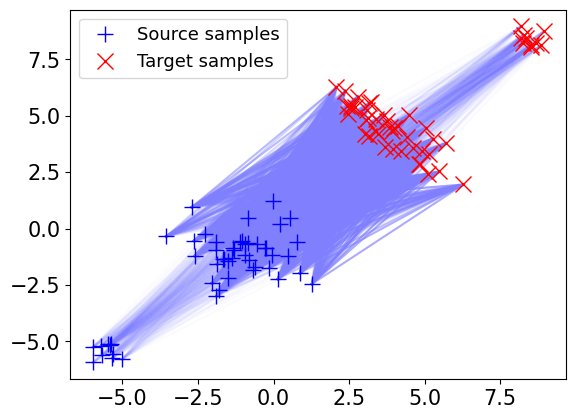

In [ ]:
pi_2 = ot.sinkhorn(a * np.exp(-(u+zeta)/tau), b * np.exp(-(v-zeta)/tau), cost + 0 * s, 0.1)

pl.figure(3)
pl.imshow(pi_2, interpolation="nearest", cmap='Blues')
pl.tick_params(labelsize=15)

pl.figure(4)
ot.plot.plot2D_samples_mat(xs, xt, pi_2, c=[0.5, 0.5, 1])
pl.plot(xs[:, 0], xs[:, 1], "+b", label="Source samples",markersize=12)
pl.plot(xt[:, 0], xt[:, 1], "xr", label="Target samples",markersize=12)
sss = pl.legend(loc=0,fontsize = 13)
pl.tick_params(labelsize=15)

sss.set_draggable(True)

pl.show()

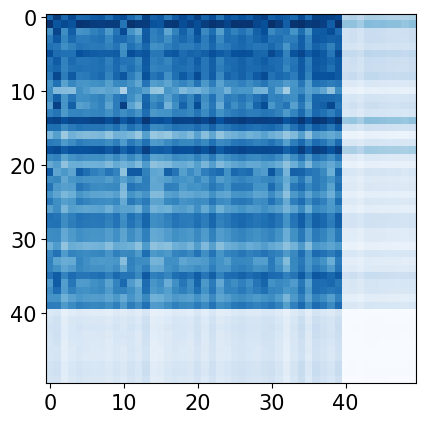

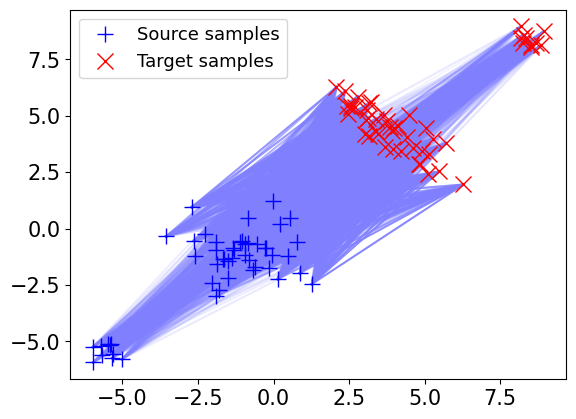

In [ ]:
entropic_kl_uot = ot.unbalanced.sinkhorn_unbalanced(a, b, cost, 0.1, tau)

pl.figure(3)
pl.imshow(entropic_kl_uot, interpolation="nearest", cmap='Blues')
pl.tick_params(labelsize=15)

pl.figure(4)
ot.plot.plot2D_samples_mat(xs, xt, entropic_kl_uot, c=[0.5, 0.5, 1])
pl.plot(xs[:, 0], xs[:, 1], "+b", label="Source samples",markersize=12)
pl.plot(xt[:, 0], xt[:, 1], "xr", label="Target samples",markersize=12)
sss = pl.legend(loc=0,fontsize = 13)
pl.tick_params(labelsize=15)

sss.set_draggable(True)

pl.show()

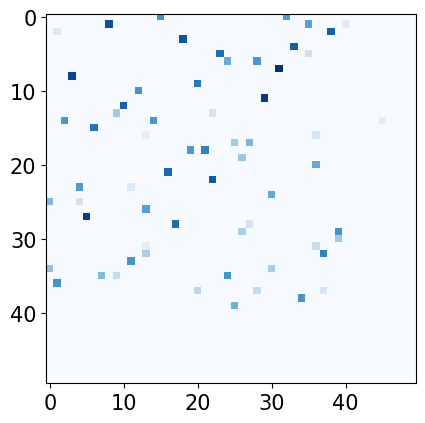

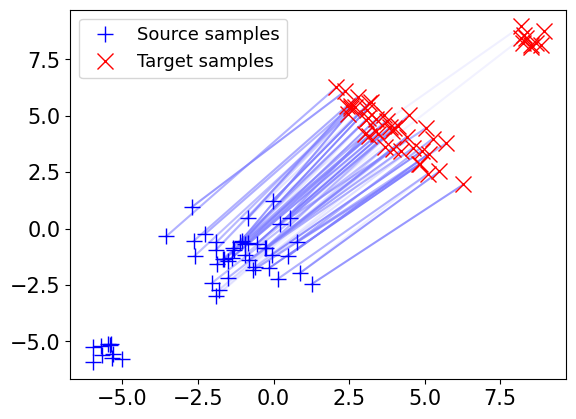

In [ ]:
pi_s = ot.smooth.smooth_ot_dual(a * np.exp(-(u+zeta)/tau), b * np.exp(-(v-zeta)/tau), cost + 100 * s, 0.1, reg_type='l2')

pl.figure(3)
pl.imshow(pi_s, interpolation="nearest", cmap='Blues')
pl.tick_params(labelsize=15)

pl.figure(4)
ot.plot.plot2D_samples_mat(xs, xt, pi_s, c=[0.5, 0.5, 1])
pl.plot(xs[:, 0], xs[:, 1], "+b", label="Source samples",markersize=12)
pl.plot(xt[:, 0], xt[:, 1], "xr", label="Target samples",markersize=12)
sss = pl.legend(loc=0,fontsize = 13)
pl.tick_params(labelsize=15)

sss.set_draggable(True)

pl.show()